In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import math


import scipy.stats as stats


from statannot import add_stat_annotation
from sklearn import metrics


import scipy.stats as stats


import re

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from grs_pca import perform_grs_pca

/slade/home/pl450/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
prefix = '/slade/home/pl450/Uveitis/GRS/python_analysis/'
data = pd.read_csv(prefix + 'allGRS_forROCAUC_220524.tsv', sep='\t', low_memory=False)

In [3]:
data = data.dropna(subset=['Sex', 'MS_GRS'])

In [4]:
data['BMI'] = data['BMI'].fillna(data['BMI'].median())
data['TDI'] = data['TDI'].fillna(data['TDI'].median())

In [5]:
data['Sex_Male'] = pd.get_dummies(data['Sex'], drop_first=True)

In [6]:
data.loc[data.white_british!=1, 'white_british'] = 0
data.loc[data.MS_any.isna(), 'MS_any'] = 0

In [8]:
def plot_roc_curve(data, features, target='Sarcoid_any', title=None):
    """
    Fits a logistic regression model using stratified 5-fold cross-validation and plots the ROC curve.

    Parameters:
    - data (pd.DataFrame): The DataFrame containing the dataset.
    - features (list): List of feature names used for prediction.
    - target (str): Name of the target variable.

    Returns:
    - None: Plots the mean ROC curve.
    """
    # Select features and target from the DataFrame
    X = data[features]
    y = data[target]

    # Create logistic regression model
    model = LogisticRegression(max_iter=200)

    # Stratified K-Folds cross-validator
    cv = StratifiedKFold(n_splits=5)

    # Variables to hold the mean FPR and TPR
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    # Perform stratified cross-validation
    for train, test in cv.split(X, y):
        model.fit(X.iloc[train], y.iloc[train])
        y_probs = model.predict_proba(X.iloc[test])[:, 1]
        fpr, tpr, thresholds = roc_curve(y.iloc[test], y_probs)
        roc_auc = auc(fpr, tpr)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        aucs.append(roc_auc)

    # Calculate the mean TPR and AUC
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    # Plot the mean ROC curve
    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='darkorange', lw=2, label=f'Mean ROC (area = {mean_auc:.4f} $\pm$ {std_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve Analysis {title or features}')  # Fix for title feature list display
    plt.legend(loc="lower right")
    plt.show()



In [48]:
def plot_roc_curve_subplot(ax, data, features, target, results_df=None):
    """
    Fits a logistic regression model using stratified 5-fold cross-validation, plots the ROC curve on the given axes object,
    and appends the results to an external DataFrame.

    Parameters:
    - ax (matplotlib.axes.Axes): The Axes object to plot on.
    - data (pd.DataFrame): The DataFrame containing the dataset.
    - features (list): List of feature names used for prediction.
    - target (str): Name of the target variable.
    - results_df (pd.DataFrame): External DataFrame to which the results are appended.
    """
    X = data[features]
    y = data[target]

    cv = StratifiedKFold(n_splits=5)
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []

    # Perform stratified cross-validation
    for train_idx, test_idx in cv.split(X, y):
        model = LogisticRegression(max_iter=200)
        model.fit(X.iloc[train_idx], y.iloc[train_idx])
        y_probs = model.predict_proba(X.iloc[test_idx])[:, 1]
        fpr, tpr, _ = roc_curve(y.iloc[test_idx], y_probs)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    sem_auc = stats.sem(aucs)
    ci = stats.t.interval(0.95, len(aucs)-1, loc=mean_auc, scale=sem_auc)
    if 'PC1' in features and 'PC5' in features:
        # Prepare non-PC features with appropriate replacements and formatting
        features_label = (', '.join([f.replace('_', '-')
                                     .replace('white british', 'Ethn')
                                     .replace(' Male', '')
                                     for f in features if not re.match(r'PC\d+', f)]))
        # Add PCs as a range if other features exist, else just the PC range
        features_label += ', PC1-5' if features_label else 'PC1-5'
    else:
        # Apply replacements and formatting to all features
        features_label = (', '.join([f.replace('_', '-')
                                     .replace('white british', 'Ethn')
                                     .replace(' Male', '')
                                     for f in features]))
    
    model = LogisticRegression()
    model.fit(X, y)
    y_probs = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, y_probs)

    ax.plot(fpr, tpr, lw=2, label=f'{features_label} (AUC={mean_auc:.3f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_title(f'{target.strip("_any")}-GRS AUROC')
    ax.legend(loc="lower right")

    if results_df is not None:
        # Append the results to the provided DataFrame
        results_df.loc[len(results_df)] = [', '.join(features), mean_auc, std_auc, ci[0], ci[1]]




def plot_grs_panels(data, targets_feature_sets, num_columns = 2,
                    figsize=[12, 6], save_label='Unnamed',
                    result_df=(pd.DataFrame(
                        columns=['Features', 'Mean AUC',
                                 'Std Dev AUC', '95% CI Lower',
                                 '95% CI Upper'])
                              )
                   ):
    """
    Plots a panel of ROC curves for each set of features associated with different targets in a single figure,
    arranging the plots in a grid of 2 columns.

    Parameters:
    - data (pd.DataFrame): The DataFrame containing the dataset.
    - targets_feature_sets (dict): Dictionary mapping target variable names to lists of feature sets.
    """
    num_targets = len(targets_feature_sets)
    num_rows = math.ceil(num_targets/num_columns)  # Compute the number of rows needed
    figsize[1] = figsize[1]*num_rows
    fig, axes = plt.subplots(num_rows, num_columns, figsize=tuple(figsize))
    axes = axes.flatten()  # Flatten the axes array to make it easier to iterate

    for ind, (ax, (target, feature_sets)) in enumerate(zip(axes, targets_feature_sets.items())):
        for features in feature_sets:
            plot_roc_curve_subplot(ax, data, features, target, results_df=result_df)
            
            # Set y-labels for only the first column
            if ind ==0 or ind%num_columns==0:
                    ax.set_ylabel('True Positive Rate')
            # else:
            #     ax.set_ylabel('')
            
            if ind//num_columns>=1:
                ax.set_xlabel('False Positive Rate')
            # else:
            #     ax.set_xlabel('')
                

    # Hide any unused axes if the number of targets is odd
    for i in range(len(targets_feature_sets), len(axes)):
        axes[i].axis('off')

    plt.tight_layout(pad=1)
    plt.savefig(save_label+'.svg')
    plt.show()

In [7]:
def generate_feature_sets(diseases, covariates=None):
    """
    Generates a dictionary mapping diseases to lists of feature sets for ROC curve analysis, with a specific exception for Rheumatoid Arthritis.

    Parameters:
    - diseases (list): List of disease names, where the GRS suffix will be appended to form the feature name.
    - covariates (list, optional): List of additional covariate names to be included in the feature sets.

    Returns:
    - dict: A dictionary where keys are disease names with '_any' suffix and values are lists of feature sets.
    """
    feature_sets_dict = {}
    covariate_list = ['Sex_Male', 'white_british'] if covariates is None else covariates

    for disease in diseases:
        if disease == 'RA':
            grs_feature = 'RhA_GRS' # Special case for Rheumatoid Arthritis
        elif disease in ["Crohns", 'UC']:
            grs_feature = 'IBD_GRS'
        else:
            grs_feature = f'{disease}_GRS'

        feature_sets = [
            [grs_feature],
            [grs_feature] + covariate_list,
            covariate_list
        ]
        feature_sets_dict[f'{disease}_any'] = feature_sets

    return feature_sets_dict


In [8]:
# Example usage:
diseases = ['AS', 'Psoriasis', 'Crohns', 'UC', 'SLE', "MS", "RA", "Sarcoid"]
additional_covariates = ['Sex_Male',
                         # 'white_british',
                         "PC1", "PC2", "PC3", "PC4", "PC5"
                        ]

feature_sets = generate_feature_sets(diseases, additional_covariates)

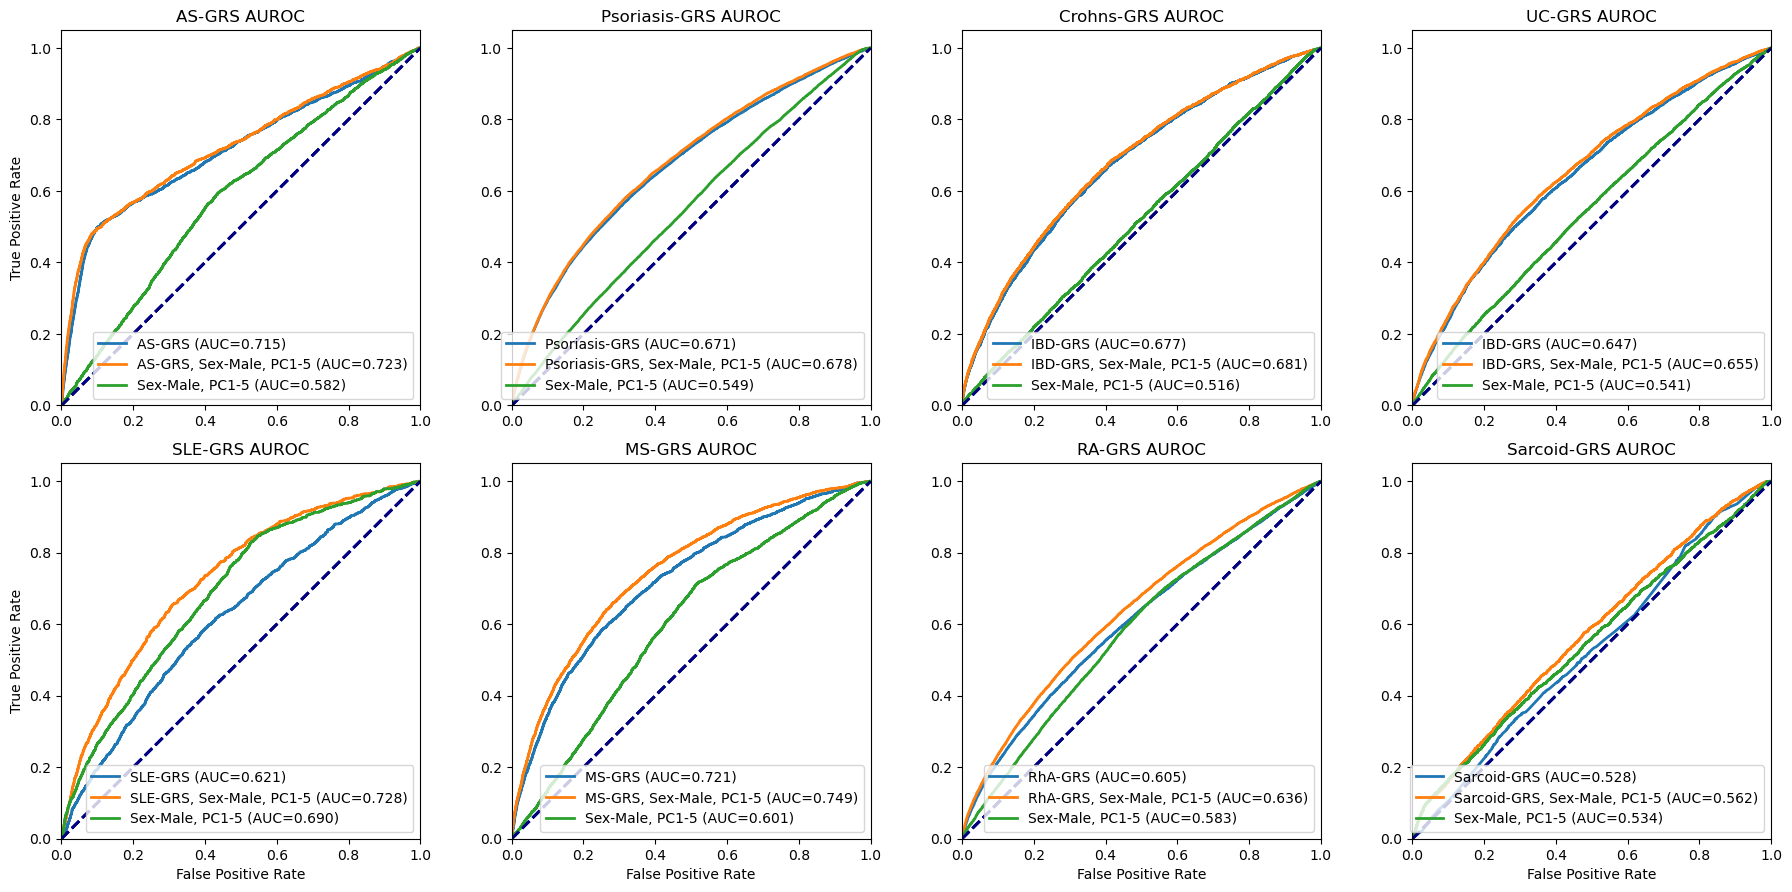

In [49]:
all_eight = pd.DataFrame(columns=['Features', 'Mean AUC',
                                   'Std Dev AUC', '95% CI Lower',
                                   '95% CI Upper'])
plot_grs_panels(data, feature_sets, num_columns=4, figsize=[18,4.5],
                save_label='EightGRS_pptx_180824', result_df=all_eight)

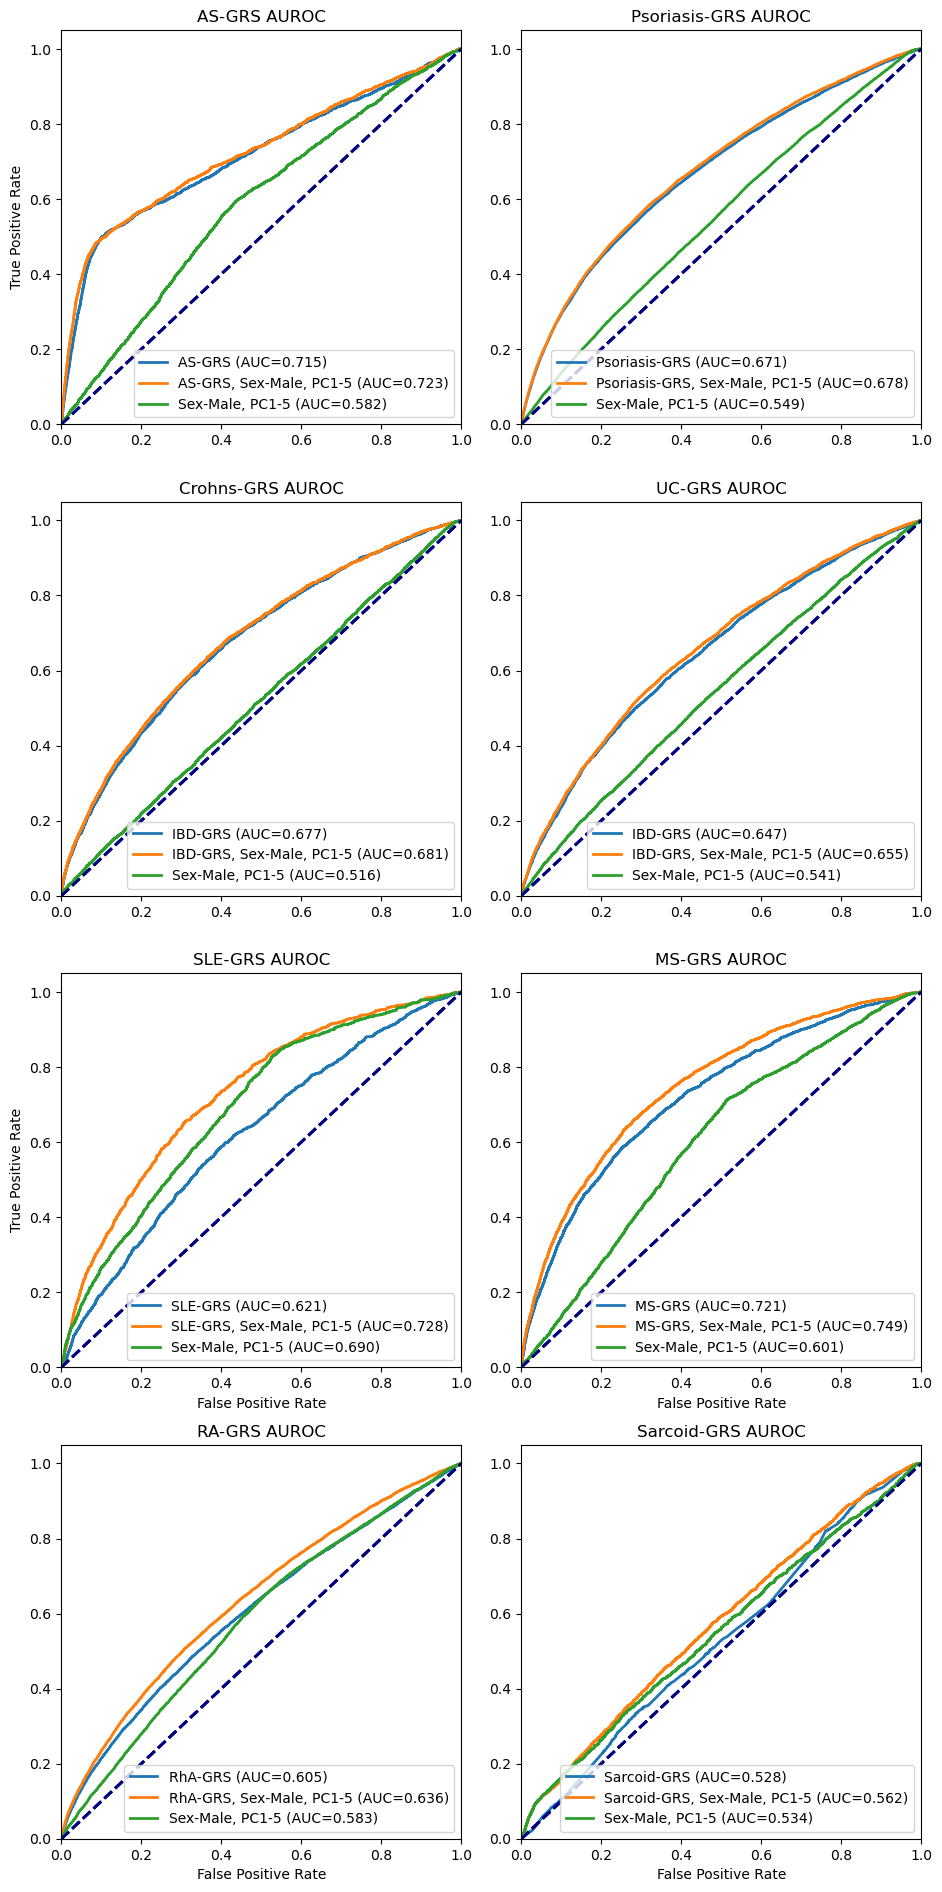

In [39]:
all_eight = pd.DataFrame(columns=['Features', 'Mean AUC',
                                   'Std Dev AUC', '95% CI Lower',
                                   '95% CI Upper'])
plot_grs_panels(data, feature_sets, num_columns=2,
                figsize=[9.5, 4.75], save_label='EightGRS_180824')

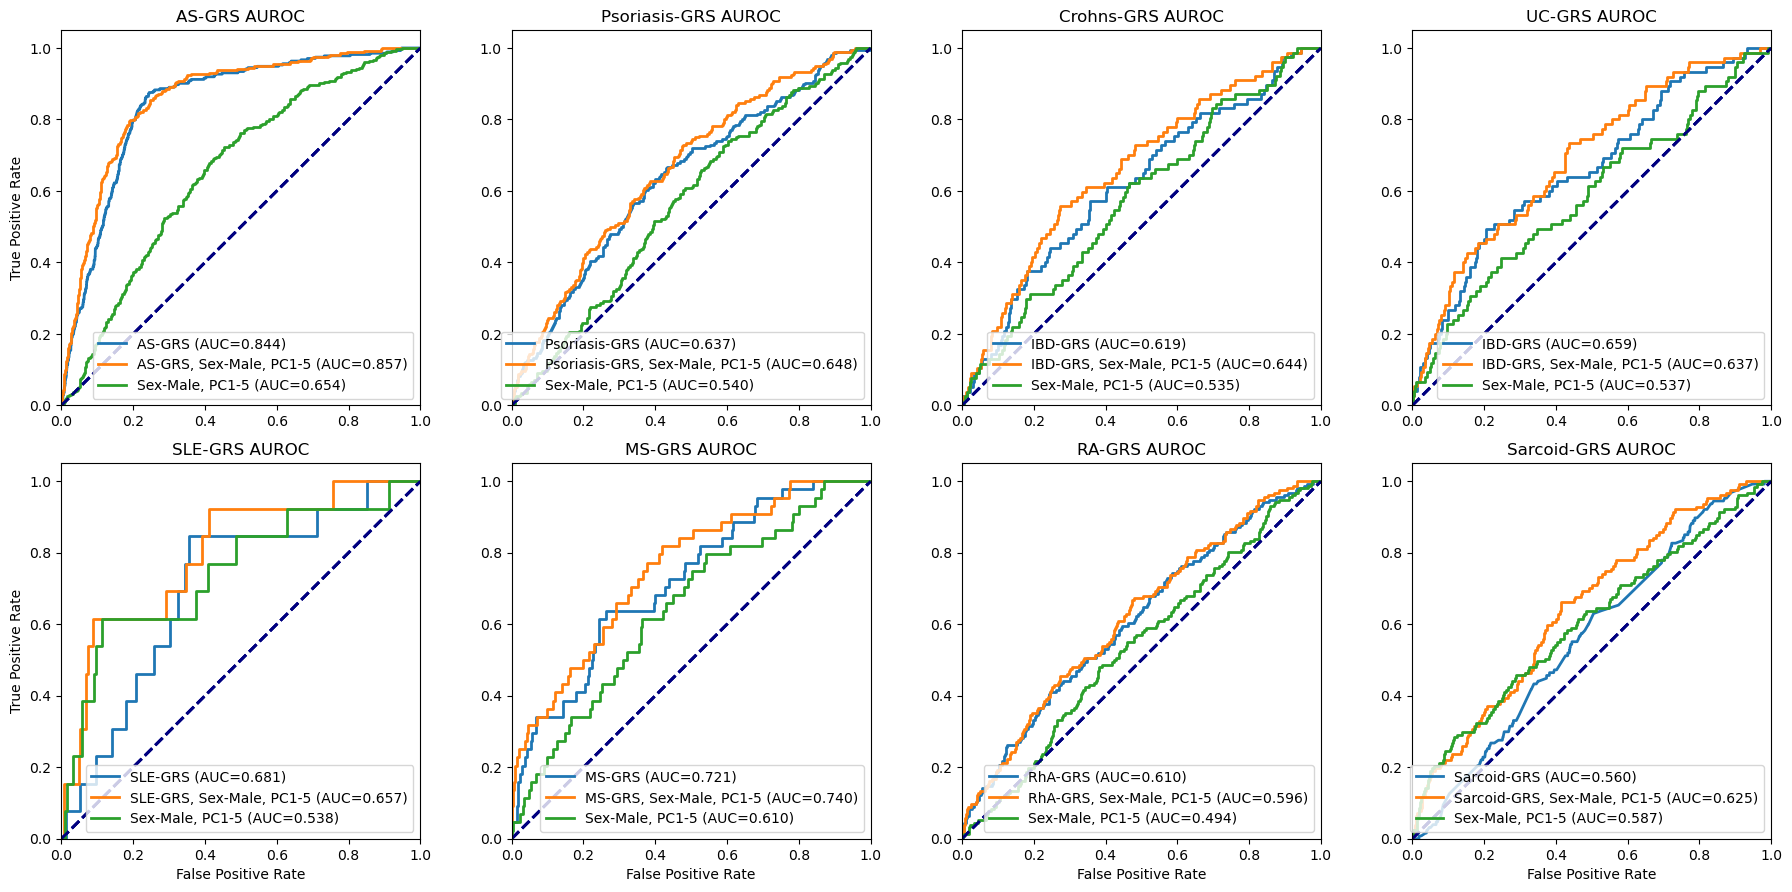

In [47]:
uve_eight = pd.DataFrame(columns=['Features', 'Mean AUC',
                                   'Std Dev AUC', '95% CI Lower',
                                   '95% CI Upper'])
plot_grs_panels(data.loc[data.uve_any==1], feature_sets, num_columns=4,
                figsize=[18, 4.5], save_label='UveOnly_EightGRS_pptx_180824',
                result_df=uve_eight)


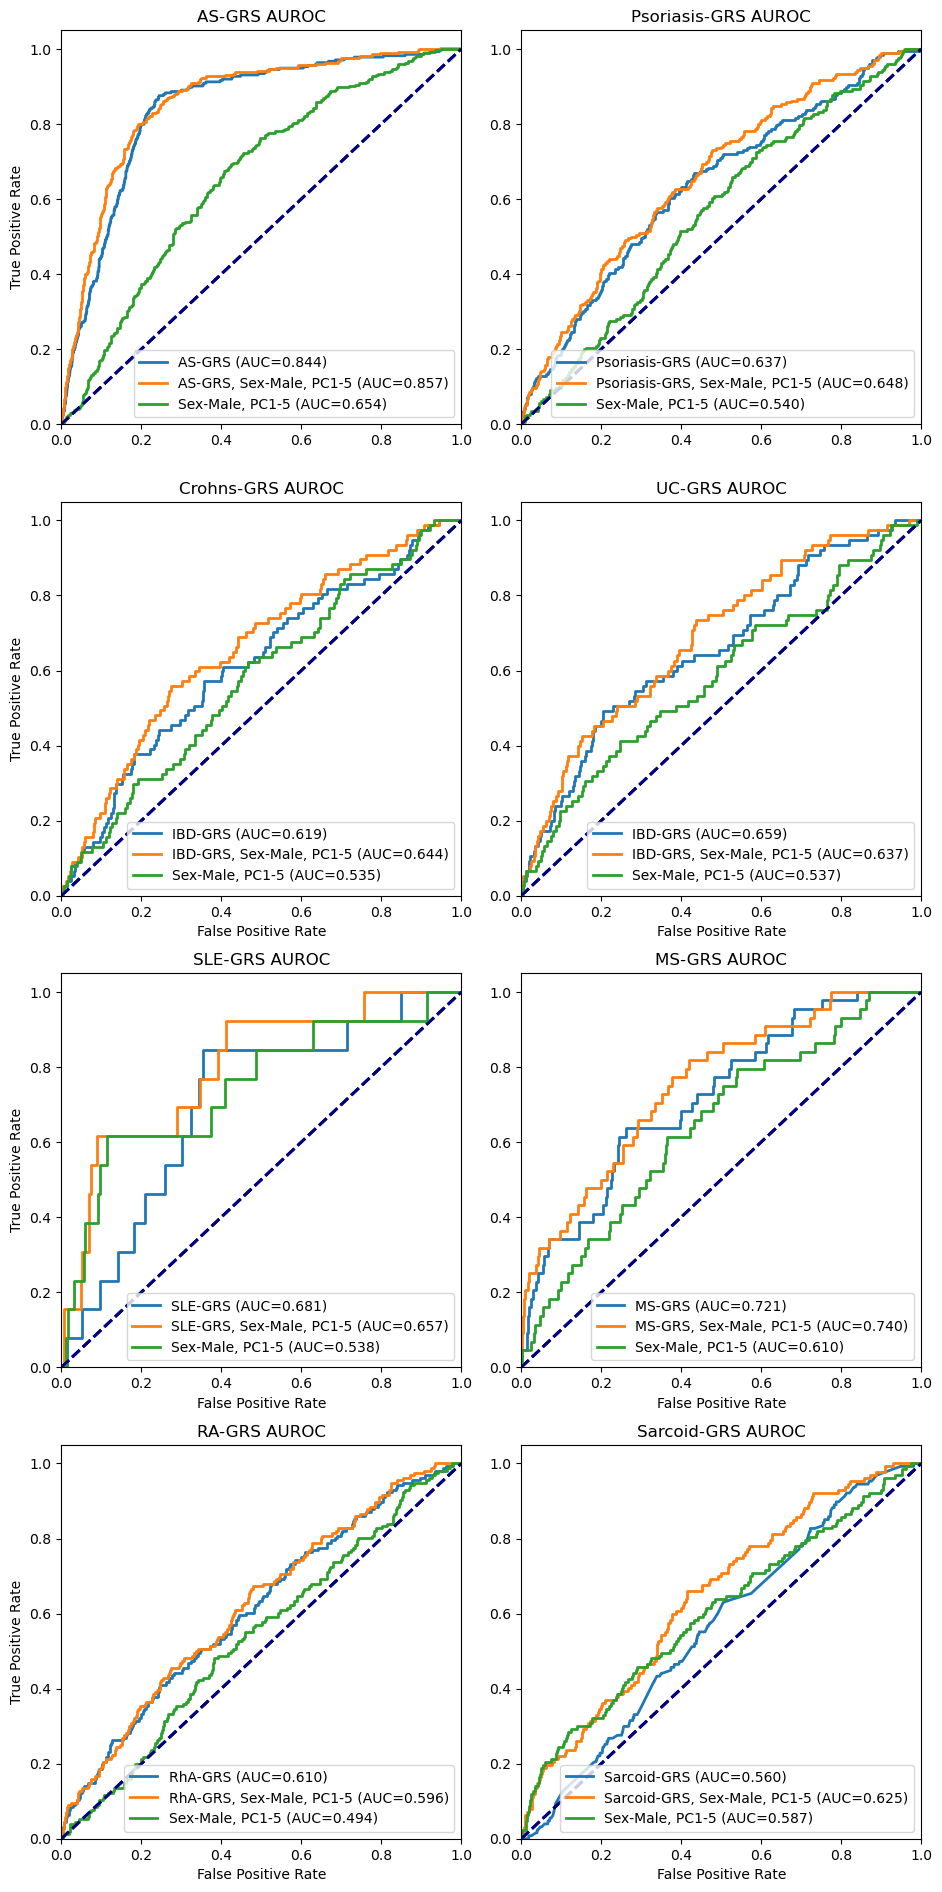

In [45]:
plot_grs_panels(data.loc[data.uve_any==1], feature_sets, num_columns=2,
                figsize=[9.5, 4.75], save_label='UveOnly_EightGRS_180824')

In [45]:
for ind, row in (all_eight.loc[((all_eight.Features.str.contains('PC')==True)
                               & (all_eight.Features.str.contains('GRS')==True))
                              ].round(3).iterrows()):
    print(row.Features)
    print(f"({row['95% CI Lower']}–{row['95% CI Upper']})")
    print("\n")

AS_GRS, Sex_Male, PC1, PC2, PC3, PC4, PC5
(0.694–0.752)


Psoriasis_GRS, Sex_Male, PC1, PC2, PC3, PC4, PC5
(0.672–0.684)


IBD_GRS, Sex_Male, PC1, PC2, PC3, PC4, PC5
(0.666–0.696)


IBD_GRS, Sex_Male, PC1, PC2, PC3, PC4, PC5
(0.646–0.665)


SLE_GRS, Sex_Male, PC1, PC2, PC3, PC4, PC5
(0.709–0.747)


MS_GRS, Sex_Male, PC1, PC2, PC3, PC4, PC5
(0.728–0.77)


RhA_GRS, Sex_Male, PC1, PC2, PC3, PC4, PC5
(0.625–0.647)


Sarcoid_GRS, Sex_Male, PC1, PC2, PC3, PC4, PC5
(0.545–0.579)




In [11]:
diseases = ['Sarcoid', 'SLE', 'Psoriasis', 'AS', 'RA', 'IBD', 'MS']
additional_covariates = ['Sex_Male', 'white_british', 'B27']

feature_sets = generate_feature_sets(diseases, additional_covariates)
#plot_grs_panels(data, feature_sets, num_columns=3, figsize=[18,6], save_label='B27sevenGRS_050724')

In [ ]:
plot_roc_curve(data.loc[data.uve_any==1], ['AS_GRS'], 'AS_any', title="AS-GRS in Uveitis cases only")

In [ ]:
plot_roc_curve(data.loc[data.uve_any==1], ['B27'], 'AS_any', title="B27 in Uveitis cases only")

In [7]:
def plot_grs_correlation_heatmap(data, grs_list, method='pearson', uveitis=False,
                                 filter_col='uve_any', additional_filter=None, 
                                 save_label='Unnamed'):
    """
    Create a heatmap of correlations between multiple Genetic Risk Scores (GRS) with Bonferroni-adjusted p-values.

    Parameters:
    data (pd.DataFrame): DataFrame containing the GRS data.
    grs_list (list): List of column names for the GRS scores.
    method (str): Correlation method ('pearson', 'spearman', or 'kendall'). Default is 'pearson'.
    uveitis (bool): Whether to filter data for uveitis cases. Default is False.
    filter_col (str): Column name for the uveitis filter. Default is 'uve_any'.
    additional_filter (dict): Additional filter to apply, specified as a dictionary with column names as keys and filter values as values.

    Returns:
    None: Displays the heatmap.
    """
    # Apply filters
    if uveitis:
        data = data.loc[data[filter_col] == 1]
    if additional_filter:
        for col, value in additional_filter.items():
            data = data.loc[data[col] == value]
    
    # Calculate the correlation matrix
    corr_matrix = data[grs_list].corr(method=method)
    
    # Function to calculate p-value
    def calculate_pvalue(x, y, method):
        if method == 'pearson':
            return stats.pearsonr(x, y)[1]
        elif method == 'spearman':
            return stats.spearmanr(x, y)[1]
        elif method == 'kendall':
            return stats.kendalltau(x, y)[1]
    
    # Calculate p-values
    n = len(grs_list)
    p_values = pd.DataFrame(np.zeros((n, n)), index=grs_list, columns=grs_list)
    for i in range(n):
        for j in range(i+1, n):
            p_value = calculate_pvalue(data[grs_list[i]], data[grs_list[j]], method)
            p_values.iloc[i, j] = p_value
            p_values.iloc[j, i] = p_value
    
    # Bonferroni correction
    num_comparisons = n * (n - 1) / 2  # number of unique pairwise comparisons
    bonferroni_threshold = 0.05 / num_comparisons
    adjusted_p_values = p_values * num_comparisons
    
    # Create significance annotation matrix
    sig_matrix = adjusted_p_values.applymap(lambda x: '***' if x < 0.001 else
                                                      ('**' if x < 0.01 else
                                                       ('*' if x < 0.05 else '')))
    
    # Set up the matplotlib figure
    plt.figure(figsize=(14, 12))
    
    # Create the heatmap
    ax = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.2f', cbar_kws={'label': 'Correlation Coefficient'})
    
    # Add significance annotations and adjusted p-values
    for i in range(n):
        for j in range(n):
            if i != j:
                plt.text(j + 0.5, i + 0.35, sig_matrix.iloc[i, j],
                         horizontalalignment='center',
                         verticalalignment='center',
                         fontsize=12, fontweight='bold')
                plt.text(j + 0.5, i + 0.7, f"p={adjusted_p_values.iloc[i, j]:.5f}",
                         horizontalalignment='center',
                         verticalalignment='center',
                         fontsize=8)
    
    # Set the title
    plt.title(f'GRS Correlation Heatmap ({method.capitalize()} correlation)' + 
              (' in Uveitis' if uveitis else '') + '\n* p<0.05, ** p<0.01, *** p<0.001 (Bonferroni-corrected)', fontsize=14)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.savefig(save_label+'.svg')
    plt.show()
    
    # Print the correlation matrix and adjusted p-values
    print("\nCorrelation Matrix:")
    print(corr_matrix.round(2))
    print("\nBonferroni-adjusted P-values:")
    print(adjusted_p_values.round(5))

In [ ]:
grs_list = ['SLE_GRS', 'MS_GRS','AS_GRS', 'IBD_GRS',
            'Psoriasis_GRS', 'RhA_GRS', 'Sarcoid_GRS']  # Add all your GRS column names here
plot_grs_correlation_heatmap(data, grs_list, method='pearson', save_label='grscorrHeatmap_050824')

In [ ]:
def plot_grs_matrix(data, disease_grs_dict, a1=0.1, a2=0.4, uveitis=False,
                    filter_col='uve_any', additional_filter=None, save_label='Unnamed'):
    """
    Plot a matrix of Genetic Risk Scores (GRS) for different diseases with optional filtering, including KDE plots on the axes.
    Perform Welch's t-test between the groups.

    Parameters:
    data (pd.DataFrame): DataFrame containing the data.
    disease_grs_dict (dict): Dictionary with disease names as keys and GRS column names as values.
    a1 (float): Alpha value for the 'other cases' points.
    a2 (float): Alpha value for the disease points.
    uveitis (bool): Whether to filter data for uveitis cases.
    filter_col (str): Column name for the uveitis filter.
    additional_filter (dict): Additional filter to apply, specified as a dictionary with column names as keys and filter values as values.
    """
    # Apply uveitis filter if specified
    if uveitis:
        data = data.loc[data[filter_col] == 1]
    
    # Apply additional filter if specified
    if additional_filter:
        for col, value in additional_filter.items():
            data = data.loc[data[col] == value]

    diseases = list(disease_grs_dict.keys())
    n = len(diseases)

    # Create a figure with a matrix of subplots
    fig, axes = plt.subplots(n, n, figsize=(5*n, 5*n))
    fig.suptitle('Matrix of Genetic Risk Scores' + (' in Uveitis' if uveitis else ''), fontsize=16)

    for i in range(n):
        for j in range(n):
            if i != j:  # Skip diagonal plots
                disease1 = diseases[i]
                disease2 = diseases[j]
                grs1 = disease_grs_dict[disease1]
                grs2 = disease_grs_dict[disease2]

                disease1_cases = data[data[f"{disease1}_any"] == 1]
                disease2_cases = data[data[f"{disease2}_any"] == 1]
                other_cases = data[(data[f"{disease1}_any"] != 1) & (data[f"{disease2}_any"] != 1)]

                # Plot scatter
                axes[i, j].scatter(other_cases[grs1], other_cases[grs2], color='green', label=f'Other Cases', alpha=a1)
                axes[i, j].scatter(disease2_cases[grs1], disease2_cases[grs2], color='orange', label=f'{disease2}', alpha=a2)
                axes[i, j].scatter(disease1_cases[grs1], disease1_cases[grs2], color='blue', label=f'{disease1}', alpha=a2)

                # Set labels and title
                axes[i, j].set_xlabel(grs1)
                axes[i, j].set_ylabel(grs2)
                axes[i, j].set_title(f'{disease1} vs {disease2}')
                axes[i, j].legend(fontsize='small')
                axes[i, j].grid(True)

                # Perform Welch's t-test
                ttest1 = stats.ttest_ind(disease1_cases[grs1], other_cases[grs1], equal_var=False)
                ttest2 = stats.ttest_ind(disease2_cases[grs2], other_cases[grs2], equal_var=False)

                # Add t-test results to the plot
                axes[i, j].text(0.05, 0.95, f"{disease1} t-stat: {ttest1.statistic:.2f}\np-value: {ttest1.pvalue:.4f}", 
                                transform=axes[i, j].transAxes, verticalalignment='top', fontsize=8)
                axes[i, j].text(0.05, 0.85, f"{disease2} t-stat: {ttest2.statistic:.2f}\np-value: {ttest2.pvalue:.4f}", 
                                transform=axes[i, j].transAxes, verticalalignment='top', fontsize=8)
            else:
                # For diagonal plots, show the distribution
                sns.histplot(data=data, x=disease_grs_dict[diseases[i]], ax=axes[i, j], kde=True)
                axes[i, j].set_title(f'Distribution of {diseases[i]} GRS')

    plt.tight_layout()
    plt.savefig(save_label+'.svg')
    plt.show()

In [ ]:
disease_grs_dict = {
    'SLE': 'SLE_GRS',
    'MS': 'MS_GRS',
    'AS':'AS_GRS',
    'IBD':'IBD_GRS',
    'Psoriasis':'Psoriasis_GRS'
}

plot_grs_matrix(data, disease_grs_dict, a2=0.8, filter_col='uve_any', uveitis=True, save_label='GRSMAtrix')

In [ ]:
plot_grs(data,'MS_GRS', 'RhA_GRS',ms_col='MS_any', sle_col='RA_any', a2=0.9, uveitis=True, filter_col='ON_any')

In [ ]:
plot_grs(data, 'ankspond_new', 'RhA_GRS', ms_col='AS_any', sle_col='RA_any',
         a2=0.6)

In [ ]:
import seaborn as sns

In [23]:
# sns.violinplot( 'AS_any', 'AS_GRS', data=data.loc[data.other_uve==1])
# plt.title('OTHER UVEITIS')

In [ ]:
data['Disease']

In [52]:
def perform_grs_pca(data, grs_list, disease_column, uveitis=False, filter_col='uve_any', additional_filter=None):
    """
    Perform PCA on Genetic Risk Scores (GRS) and visualize the results with disease-based coloring.
    
    Parameters:
    data (pd.DataFrame): DataFrame containing the GRS data and disease information.
    grs_list (list): List of column names for the GRS scores.
    disease_column (str): Column name containing disease information.
    uveitis (bool): Whether to filter data for uveitis cases. Default is False.
    filter_col (str): Column name for the uveitis filter. Default is 'uve_any'.
    additional_filter (dict): Additional filter to apply, specified as a dictionary with column names as keys and filter values as values.
    
    Returns:
    pca: The fitted PCA object.
    df_pca: DataFrame with PCA results and disease information.
    """
    # Make a copy of the data to avoid modifying the original
    data_copy = data.copy()
    
    # Apply filters
    if uveitis:
        data_copy = data_copy.loc[data_copy[filter_col] == 1]
    if additional_filter:
        for col, value in additional_filter.items():
            data_copy = data_copy.loc[data_copy[col] == value]
    
    # Check for missing data in GRS columns and disease column
    missing_grs = data_copy[grs_list].isnull().sum()
    missing_disease = data_copy[disease_column].isnull().sum()
    
    print(f"Missing values in GRS columns:\n{missing_grs}")
    print(f"Missing values in disease column: {missing_disease}")
    
    # Remove rows with missing data
    data_clean = data_copy
    
    print(f"Original data shape: {data.shape}")
    print(f"Filtered data shape: {data_copy.shape}")
    print(f"Clean data shape: {data_clean.shape}")
    
    # Prepare the data for PCA
    X = data_clean[grs_list]
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Perform PCA
    pca = PCA(n_components=len(grs_list))
    pca_result = pca.fit_transform(X_scaled)
    
    # Create a DataFrame with PCA results
    df_pca = pd.DataFrame(data=pca_result[:, :2], columns=['PC1', 'PC2'])
    df_pca['Disease'] = data[disease_column]
    
    # Check unique disease values and their counts
    disease_counts = df_pca['Disease'].value_counts()
    print(f"Disease value counts:\n{disease_counts}")
    
    # Visualize the results with disease-based coloring
    plt.figure(figsize=(10, 10*.8))
    sns.scatterplot(data=df_pca, x='PC1', y='PC2',hue='Disease', palette='deep')
    plt.title('PCA of Genetic Risk Scores Colored by Disease')
    plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.2%})')
    plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.2%})')
    plt.legend(title='Disease', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('PCA_allUKBB_180824.svg')
    plt.show()
    
    # Plot explained variance ratio
    plt.figure(figsize=(8, 8))
    plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance Ratio by Principal Component')
    plt.tight_layout()
    plt.show()
    
    # Print cumulative explained variance ratio
    cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
    print("Cumulative Explained Variance Ratio:")
    for i, ratio in enumerate(cumulative_variance_ratio, 1):
        print(f"PC{i}: {ratio:.4f}")
    
    # Visualize the loadings
    loadings = pd.DataFrame(
        data=pca.components_.T * np.sqrt(pca.explained_variance_),
        columns=[f'PC{i}' for i in range(1, len(grs_list) + 1)],
        index=grs_list
    )
    plt.figure(figsize=(10, 8))
    sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0)
    plt.title('PCA Loadings Heatmap')
    plt.tight_layout()
    plt.show()
    
    return pca, df_pca

Missing values in GRS columns:
AS_GRS           0
IBD_GRS          0
Psoriasis_GRS    0
SLE_GRS          0
MS_GRS           0
RhA_GRS          0
Sarcoid_GRS      0
dtype: int64
Missing values in disease column: 0
Original data shape: (483480, 127)
Filtered data shape: (483480, 127)
Clean data shape: (483480, 127)
Disease value counts:
Controls     447062
Psoriasis     13233
RA             8347
UC             2906
Uveitis        2754
MS             2318
Crohns         2305
Sarcoid        1918
AS             1670
SLE             967
Name: Disease, dtype: int64


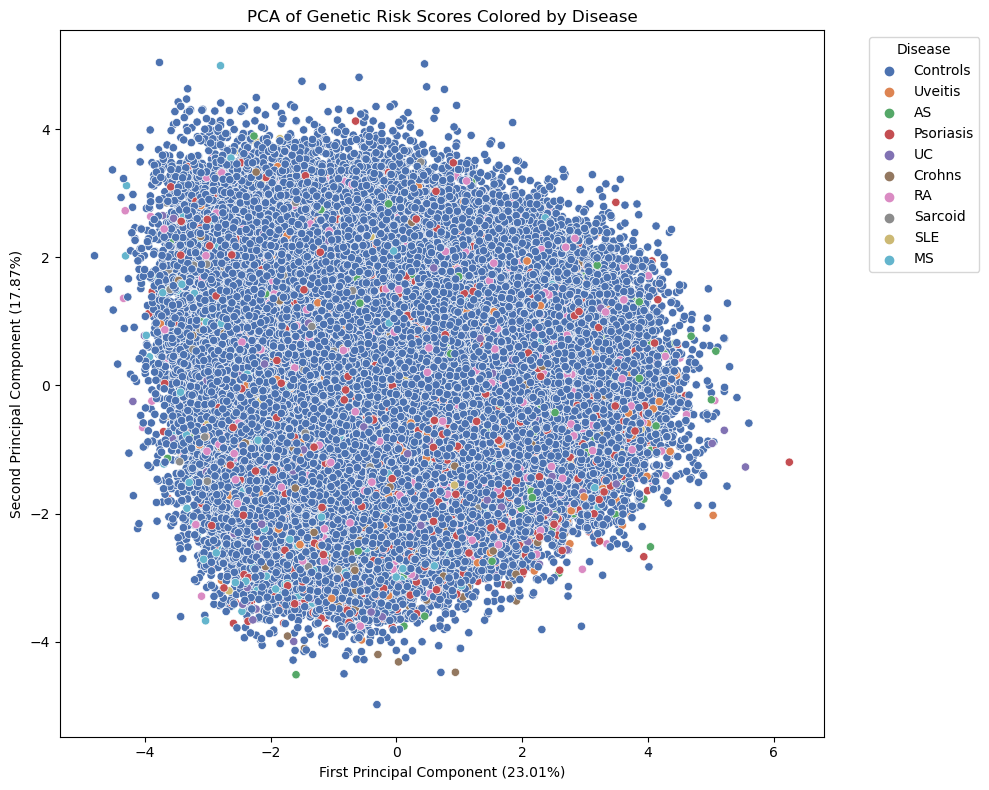

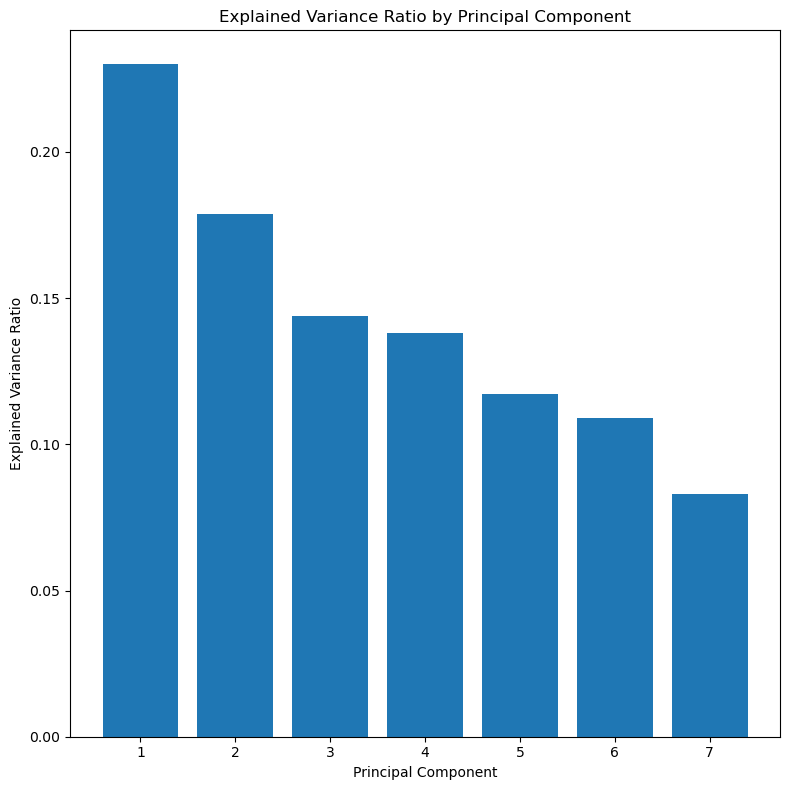

Cumulative Explained Variance Ratio:
PC1: 0.2301
PC2: 0.4088
PC3: 0.5528
PC4: 0.6908
PC5: 0.8080
PC6: 0.9170
PC7: 1.0000


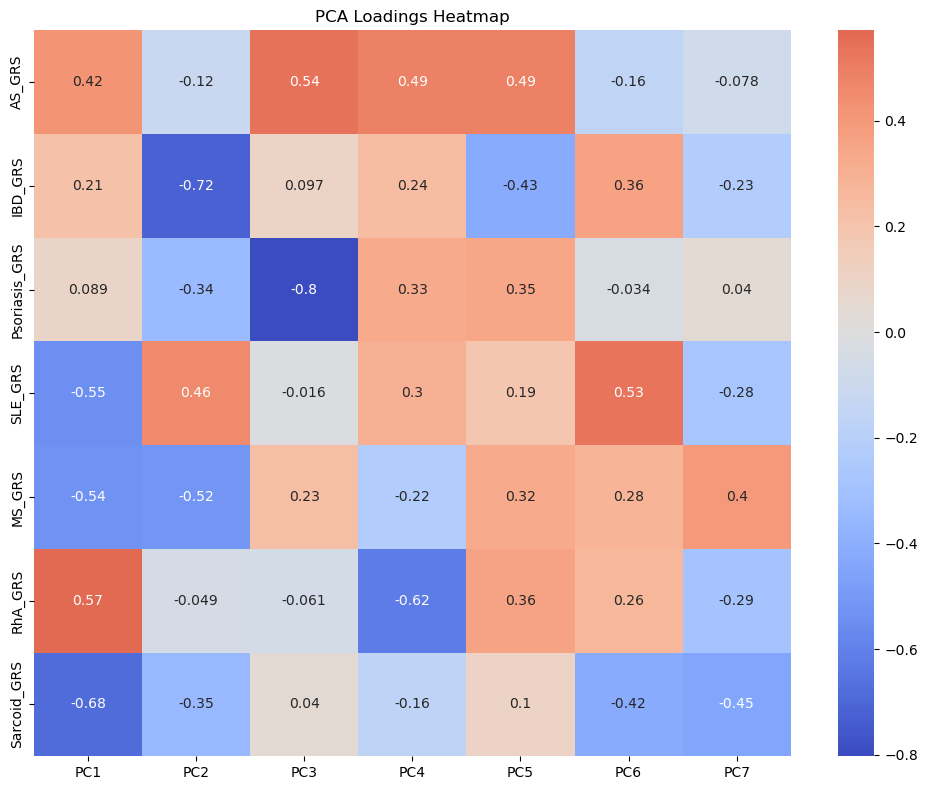

(PCA(n_components=7),
              PC1       PC2    Disease
 0      -0.505069 -1.597019   Controls
 1       0.047761 -0.854731   Controls
 2      -1.352054 -0.348220   Controls
 3       0.342997  0.179294   Controls
 4       0.238972  1.337531   Controls
 ...          ...       ...        ...
 483475 -1.958575 -1.318459  Psoriasis
 483476  1.394222  1.087105   Controls
 483477 -1.091793  0.294890   Controls
 483478  1.521318  1.013684   Controls
 483479  1.313641  0.524658   Controls
 
 [483480 rows x 3 columns])

In [53]:
grs_list = ['AS_GRS', 'IBD_GRS', 'Psoriasis_GRS' ,
                'SLE_GRS', 'MS_GRS','RhA_GRS', 'Sarcoid_GRS']
disease_list = ['AS', 'Crohns', 'UC', 'Psoriasis',
                    'SLE', "MS", "RA", "Sarcoid"]
disease_list = [i+"_any" for i in disease_list]

perform_grs_pca(data, grs_list, 'Disease')

In [29]:
data['Disease'] = 'Controls'

In [30]:
data.loc[data['uve_any']==1, 'Disease'] = 'Uveitis'
for i in disease_list:
    data.loc[data[i]==1, 'Disease'] = i.rstrip('_any')

In [28]:
data.Disease.value_counts()

Controls     447062
Psoriasis     13233
RA             8347
UC             2906
uveitis        2754
MS             2318
Crohns         2305
Sarcoid        1918
AS             1670
SLE             967
Name: Disease, dtype: int64

Index(['MS_GRS', 'RhA_HLA_GRS', 'RhA_nonHLA_GRS', 'RhA_GRS', 'AS_GRS',
       'Sarcoid_HLA_GRS', 'Sarcoid_GRS', 'SLE_GRS', 'IBD_GRS', 'Psoriasis_GRS',
       'first_uve_RA', 'first_RA', 'first_uve_AS', 'first_AS',
       'first_uve_Behcets', 'first_Behcets', 'first_uve_Crohns',
       'first_Crohns', 'first_uve_Psoriasis', 'first_Psoriasis',
       'first_uve_Sarcoid', 'first_Sarcoid', 'first_uve_Sjo', 'first_Sjo',
       'first_uve_SLE', 'first_SLE', 'first_uve_UC', 'first_UC',
       'first_uve_Weg', 'first_Weg', 'first_uve_CS', 'first_CS',
       'first_uve_mpa', 'first_mpa', 'first_uve_GCA', 'first_GCA', 'first_MS',
       'first_ON', 'first_uve_MS', 'first_uve_IBD'],
      dtype='object')